![data cube logo](https://static.wixstatic.com/media/8959d6_a13dc7ece5be4678af57c8f7c1667734~mv2.png/v1/fill/w_279,h_177,al_c,q_85,usm_0.66_1.00_0.01,enc_auto/VSDC_DataCubeSplash_6Partner_edited.png)
# Land Surface Temperature Example for Southern Virginia

 - Sign up to the [VA Datacube](https://datacube.vmasc.org/) to run this notebook interactively from a browser   

 - <b>Products used</b>:
    - Landsat 8 (`ls8_c2l2_st`)
 
 - <b>Special requirements:</b> There are no special requirements. 
 
 - <b>Prerequisites:</b> There are no prerequisites.
 
 - <b>Notebook Use:</b> If you would like to modify and save this notebook, please copy and paste it into your own folder on the data cube and make sure to enable your version control.


## Background


For over three decades, the United States Geological Survey’s (USGS) Landsat satellite program has been diligently capturing images of the Earth's surface. These images are invaluable for a wide range of studies, including mapping land and coastal areas. Beyond just capturing surface reflectance data, Landsat also provides information on surface temperature.

Surface temperature data, measured in Kelvin and converted here to Celcius, offers critical insights into various aspects of Earth's environment. It plays a key role in understanding global energy balance and hydrological processes. Additionally, surface temperature data is instrumental in monitoring the health of crops and vegetation. It helps detect anomalies such as extreme heat events caused by natural disasters like volcanic eruptions or wildfires. Furthermore, surface temperature data aids in studying urban heat island effects, providing crucial information for urban planning and climate resilience strategies.

For more information and caveats of the product, visit the [Landsat Science Products Overview and the Landsat Surface Temperature](https://www.usgs.gov/landsat-missions/landsat-collection-2-surface-temperature#:~:text=Landsat%20surface%20temperature%20measures%20the,balance%20studies%20and%20hydrologic%20modeling.) webpage.



## Description

In this notebook, we will show how to query and clean up the land surface temperature (LST) data in southeastern Virginia. 

1. First we will load the measurements from Landsat 8
2. Next we will convert the and clean up the data
3. Finally we will plot a simple timeseries 

---------------------------------------------------------------------------------------------------------------------------

## Getting started


Provide any particular instructions that the user might need, e.g. To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

### Load packages
Import Python packages that are used for the analysis.

Use standard import commands; some are shown below. Begin with any iPython magic commands, followed by standard Python packages, then any additional functionality you need from the Scripts directory.

In [1]:
%matplotlib inline

import datacube
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from deafrica_tools.load_era5 import load_era5
from deafrica_tools.datahandling import load_ard, mostcommon_crs
from deafrica_tools.plotting import display_map, rgb

from datacube.utils.aws import configure_s3_access
configure_s3_access(profile='default', requester_pays=True)
from odc.ui import with_ui_cbk


### Connect to the datacube

Connect to the datacube so we can access DEA data. The app parameter is a unique name for the analysis which is based on the notebook file name

In [2]:
dc = datacube.Datacube(app='LST_Derived')

## Load the Landsat 8 LST product



We will first list all the Landsat LST data products in the server.

In [3]:
# List Landsat products available in DE Africa
dc_products = dc.list_products()
display_columns = ['name', 'description']
dc_products[dc_products.name.str.contains(
    '_st').fillna(
        False)][display_columns].set_index('name')

,description
name,
ls5_c2l2_st,USGS Landsat 5 Collection 2 Level-2 Surface Te...
ls7_c2l2_st,USGS Landsat 7 Collection 2 Level-2 Surface Te...
ls8_c2l2_st,USGS Landsat 8 Collection 2 Level-2 Surface Te...
ls9_c2l2_st,USGS Landsat 9 Collection 2 Level-2 Surface Te...


Now, let's look at Landsat 8's measurements. 

In [4]:
#List measurements
dc_measurements = dc.list_measurements()
dc_measurements.loc['ls8_c2l2_st']

,name,dtype,units,nodata,aliases,flags_definition
measurement,,,,,,
lwir11,lwir11,uint16,Kelvin,0.0,"[lwir, band_6, st, surface_temperature]",NaN
TRAD,TRAD,int16,W/(m2.sr.μm),-9999.0,"[trad, ST_TRAD, thermal_radiance]",NaN
URAD,URAD,int16,W/(m2.sr.μm),-9999.0,"[urad, ST_URAD, upwell_radiance]",NaN
DRAD,DRAD,int16,W/(m2.sr.μm),-9999.0,"[drad, ST_DRAD, downwell_radiance]",NaN
ATRAN,ATRAN,int16,1,-9999.0,"[atran, ST_ATRAN, atmospheric_transmittance]",NaN
EMIS,EMIS,int16,1,-9999.0,"[emis, ST_EMIS, emissivity]",NaN
EMSD,EMSD,int16,1,-9999.0,"[emsd, ST_EMSD, emissivity_stddev]",NaN
CDIST,CDIST,int16,Kilometers,-9999.0,"[cdist, ST_CDIST, cloud_distance]",NaN
qa,qa,int16,Kelvin,-9999.0,"[st_qa, surface_temperature_quality]",NaN


We can see several "bands" we will make use of. These are `lwir11` for surface temperature, `qa_pixel`, and `CDIST`. Others here can be used for your custom algorithms.

Note that the `lwir11` band, long wave infrared, is the surface temperature band. In other LST Landsat products, we noticed this band may be named "surface_temperature" (as seen in the African Data Cube) or "lwir11". Please be mindful when comparing satellite products indexed here versus elsewhere. 

### Study Area
Let's define our region of interest. In this case, it is located in southeastern Virginia. Here, the collection of counties is locally called "Hampton Roads". 

In [5]:
# Define the analysis region (Lat-Lon box)
lat = 36.7401 
lon = -76.2891 

#This is going to control how large the study area is. 
lon_buffer = 0.3
lat_buffer = 0.3

# Define the time window
time_range = ('2021-05', '2021-10')

# Combine central lat,lon with buffer to get area of interest
lat_range = (lat-lat_buffer, lat+lat_buffer)
lon_range = (lon-lon_buffer, lon+lon_buffer)

# Load land surface temperature and quality assessment
# We can use the alias names to call the bands with qa** and CDIST serving to help us get rid of clouds and water in our dataset. 
measurements = ['lwir11', 'qa_pixel', 'qa', 'CDIST']


In [6]:
display_map(x=lon_range, y=lat_range)

/opt/tljh/user/lib/python3.9/site-packages/deafrica_tools/plotting.py:284: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  all_longitude, all_latitude = transform(Proj(crs), Proj("EPSG:4326"), all_x, all_y)


Looking at the above, we would suspect the Great Dismal Swamp National Wildlife Refuge to have a lower LST than the urban areas around Norfolk and northern Chesapeake. In a nutshell, this is due to transpiration in plants. 

Let's query the data to the region of interest and time window above. We will use the May to October 2021 window to capture the full length of summer along with the ends and starts of the transition seasons of fall and spring. 

In [7]:
# Create a reusable query
query = {
    'y': lat_range,
    'x': lon_range,
    'time': time_range,
    'measurements': measurements,
    'resolution': (-30, 30),
    'output_crs': 'epsg:6933',
    'group_by':'solar_day'
}

# Load available data from Sentinel-2
ds = dc.load(
    product=['ls8_c2l2_st'],
    progress_cbk=with_ui_cbk(),
    **query
)

print(ds)

<xarray.Dataset>
Dimensions:      (time: 23, y: 2055, x: 1931)
Coordinates:
  * time         (time) datetime64[ns] 2021-05-06T15:40:08.945143 ... 2021-10...
  * y            (y) float64 4.41e+06 4.41e+06 4.41e+06 ... 4.349e+06 4.349e+06
  * x            (x) float64 -7.39e+06 -7.39e+06 ... -7.332e+06 -7.332e+06
    spatial_ref  int32 6933
Data variables:
    lwir11       (time, y, x) uint16 42069 42067 42069 ... 35075 35057 35111
    qa_pixel     (time, y, x) uint16 21952 21952 21952 ... 22280 22280 22280
    qa           (time, y, x) int16 212 212 212 212 212 ... 825 826 827 827 826
    CDIST        (time, y, x) int16 697 699 700 702 704 706 708 ... 0 0 0 0 0 0
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref


## Using QA bands to filter LST Data

Below we will now use the bit-based QA bands to filter out the data and convert from digital number to degrees Celsius.

In [24]:
#Make copy of the dataarray to make quality assurance (QA) modifications to
ds_1 = ds.copy()

print(ds_1)

<xarray.Dataset>
Dimensions:      (time: 23, y: 2055, x: 1931)
Coordinates:
  * time         (time) datetime64[ns] 2021-05-06T15:40:08.945143 ... 2021-10...
  * y            (y) float64 4.41e+06 4.41e+06 4.41e+06 ... 4.349e+06 4.349e+06
  * x            (x) float64 -7.39e+06 -7.39e+06 ... -7.332e+06 -7.332e+06
    spatial_ref  int32 6933
Data variables:
    lwir11       (time, y, x) uint16 42069 42067 42069 ... 35075 35057 35111
    qa_pixel     (time, y, x) uint16 21952 21952 21952 ... 22280 22280 22280
    qa           (time, y, x) int16 212 212 212 212 212 ... 825 826 827 827 826
    CDIST        (time, y, x) int16 697 699 700 702 704 706 708 ... 0 0 0 0 0 0
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref


We used this USGS document to navigate which bit levels to filter out: [link](https://d9-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/media/files/LSDS-1328_Landsat8-9_OLI-TIRS-C2-L2_DFCB-v7.pdf). Here, you will also find descriptions for how the data was prepared by USGS. 

For other Landsats, check out [this page](https://www.usgs.gov/landsat-missions/landsat-collection-2-surface-temperature#:~:text=Landsat%20surface%20temperature%20measures%20the,balance%20studies%20and%20hydrologic%20modeling.) from USGS for more information. 

In [25]:
# Create a cloud mask
cloud_mask = np.bitwise_and(ds_1['qa_pixel'], 2**7) > 0 #instead of 2**3, 4, , 7 this says landsat bit 7 is water mask

#cloud distance conversion
ds_1['CDIST'] = ds_1.CDIST * 0.01

print("before filter:", ds_1)

# Optionally, refine cloud mask using cloud distance band
cloud_mask = cloud_mask | (np.bitwise_and(ds_1['qa_pixel'], 2**4) > 0) | (np.bitwise_and(ds_1['qa_pixel'], 2**0) > 0) | (np.bitwise_and(ds_1['qa_pixel'], 2**2) > 0) | (np.bitwise_and(ds_1['qa_pixel'], 2**1) > 0) | (np.bitwise_and(ds_1['qa_pixel'], 2**3) > 0) # | (np.bitwise_and(ds['qa_pixel'], 2**3) > 0)


# Apply cloud mask to surface temperature DataArray
surface_temp_filtered = ds_1['lwir11'].where(~cloud_mask)

# Create a new Dataset with the filtered surface temperature DataArray
ds_filtered = xr.Dataset({'surface_temperature': surface_temp_filtered})

#Filter out no data values
ds_filtered = ds_filtered.where(ds_filtered['surface_temperature'] != 0, drop=True)

# Check the filtered dataset
print("Filtered:", ds_filtered)


before filter: <xarray.Dataset>
Dimensions:      (time: 23, y: 2055, x: 1931)
Coordinates:
  * time         (time) datetime64[ns] 2021-05-06T15:40:08.945143 ... 2021-10...
  * y            (y) float64 4.41e+06 4.41e+06 4.41e+06 ... 4.349e+06 4.349e+06
  * x            (x) float64 -7.39e+06 -7.39e+06 ... -7.332e+06 -7.332e+06
    spatial_ref  int32 6933
Data variables:
    lwir11       (time, y, x) uint16 42069 42067 42069 ... 35075 35057 35111
    qa_pixel     (time, y, x) uint16 21952 21952 21952 ... 22280 22280 22280
    qa           (time, y, x) int16 212 212 212 212 212 ... 825 826 827 827 826
    CDIST        (time, y, x) float64 6.97 6.99 7.0 7.02 ... 0.0 0.0 0.0 0.0
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref
Filtered: <xarray.Dataset>
Dimensions:              (time: 23, y: 2055, x: 1931)
Coordinates:
  * time                 (time) datetime64[ns] 2021-05-06T15:40:08.945143 ......
  * y                    (y) float64 4.41e+06 4.41e+06 ... 4.349e+06 4.

### Convert from digital number to Celsius
We will use the equation given by USGS for converting the numbers for this instrument. Note that this will be different for different Landsats. 

In [26]:
# Convert from digital number (DN) to Kelvin to Celsius: https://www.usgs.gov/faqs/how-do-i-use-a-scale-factor-landsat-level-2-science-products
# see also: https://www.usgs.gov/media/files/landsat-8-9-collection-2-level-2-science-product-guide

ds_filtered = ds_filtered.dropna(dim='time', how='all')

ds_filtered['surface_temperature'] = ((ds_filtered.surface_temperature * 0.00341802) + 149) - 273.15

# Filter pixels with temperatures greater than 0°C
filtered_ds = ds_filtered.where(ds_filtered['surface_temperature'] >= 0)

print(ds_filtered)

<xarray.Dataset>
Dimensions:              (time: 21, y: 2055, x: 1931)
Coordinates:
  * time                 (time) datetime64[ns] 2021-05-06T15:40:08.945143 ......
  * y                    (y) float64 4.41e+06 4.41e+06 ... 4.349e+06 4.349e+06
  * x                    (x) float64 -7.39e+06 -7.39e+06 ... -7.332e+06
    spatial_ref          int32 6933
Data variables:
    surface_temperature  (time, y, x) float64 nan nan nan nan ... nan nan nan


### Plot the Filtered Data
Let's now plot the LST data for the region. Note the white space; that will be the parts filtered out. 

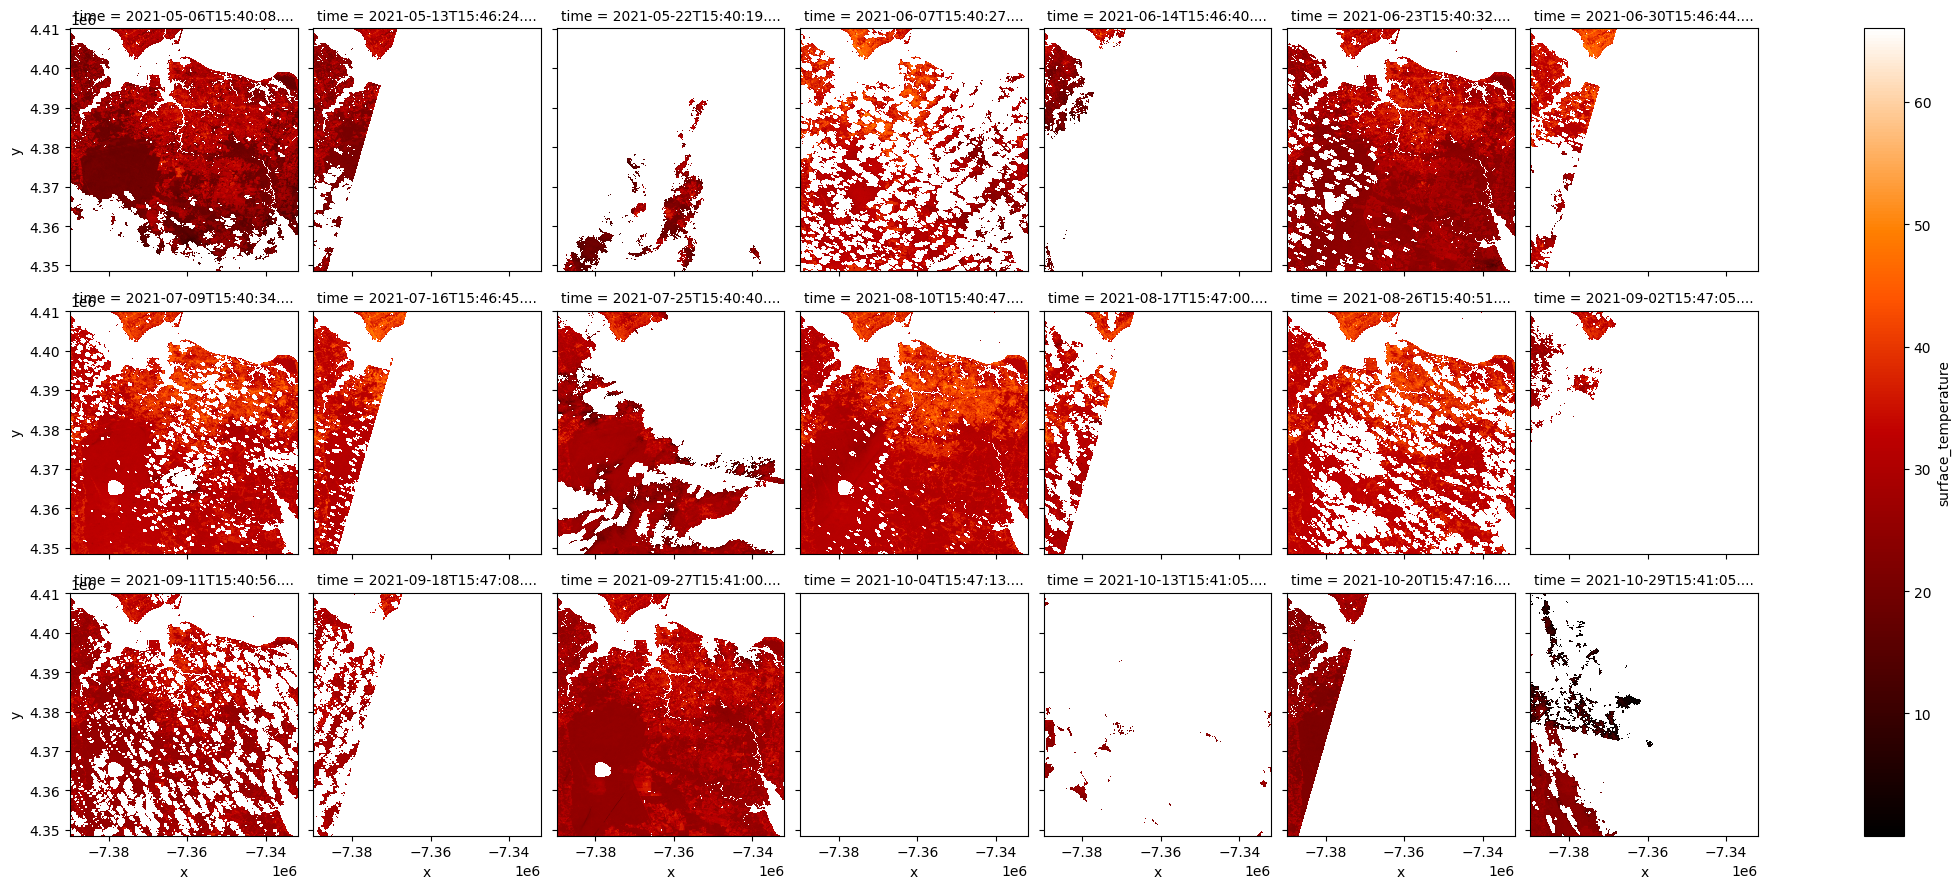

In [27]:
filtered_ds.surface_temperature.plot.imshow(col='time', col_wrap=7, cmap='gist_heat');

We can see that 21 scenes were found in the time window we gave. Of the 21, one in October is not usable. The rest have at least some pixels that can be combined via the median or mean (seen later in this notebook). Let's see what the time series looks like. 

## LST Timeseries

Let's create a simple time series for LST between May and October 2021 using the median of the pixels in each scene seen above. 


In [28]:
# Calculate mean
ds_med = filtered_ds.groupby('time').median(dim=xr.ALL_DIMS)

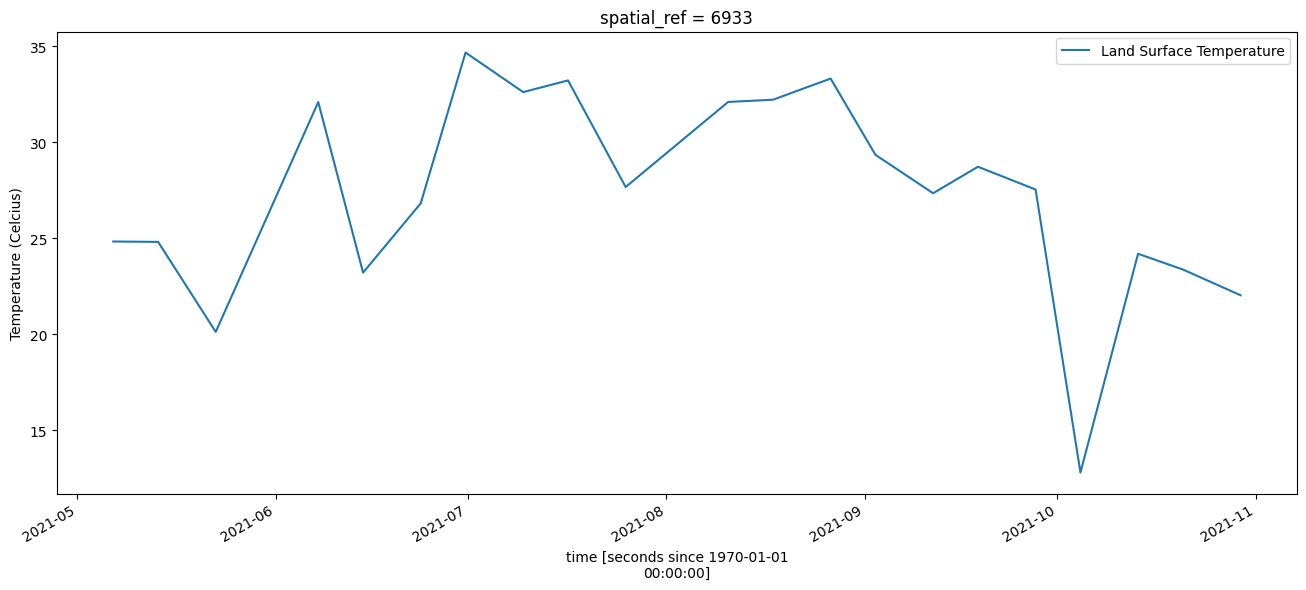

In [29]:
# Plot
ds_med.surface_temperature.plot(figsize = (16, 6),label='Land Surface Temperature');
plt.ylabel('Temperature (Celcius)')
plt.legend()

We can see a general trend of the seasons spring and fall being generally cooler than the summer. It appears that in this area in 2021, the peak LST occurred in July. 

Now we will gather the median, mean, standard deviation, and interquartile range of LST for the whole area to compare how each highlights different features. 

/opt/tljh/user/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


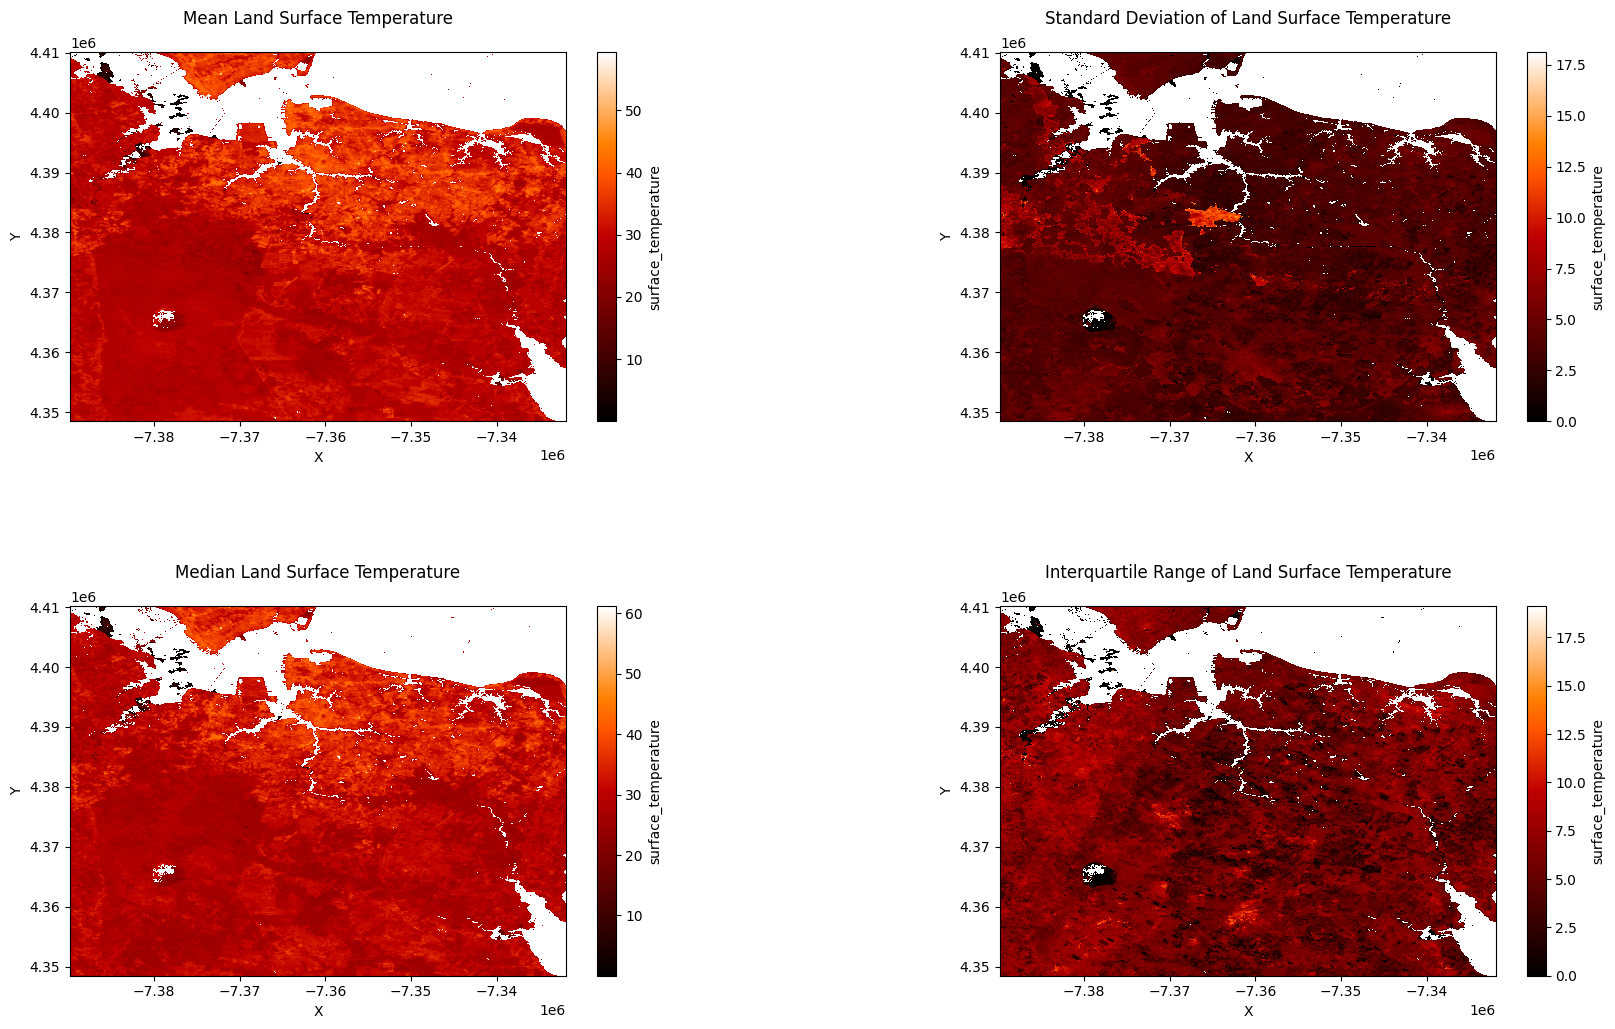

In [30]:
# Calculate the mean, standard deviation, median, and median absolute deviation along the time dimension
mean_temperature = filtered_ds['surface_temperature'].mean(dim='time')
std_temperature = filtered_ds['surface_temperature'].std(dim='time')
med_temperature = filtered_ds['surface_temperature'].median(dim='time')

# Calculate the interquartile range (IQR) along the time dimension
q1 = filtered_ds['surface_temperature'].quantile(0.25, dim='time')
q3 = filtered_ds['surface_temperature'].quantile(0.75, dim='time')
iqr_temperature = q3 - q1

# Create a figure with four subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))

# Plot the mean temperature on the left subplot
mean_temperature.plot(cmap='gist_heat', ax=ax1)
ax1.set_title('Mean Land Surface Temperature', pad=20)  # Adjust title position
ax1.set_xlabel('X')
ax1.set_ylabel('Y')

# Plot the standard deviation on the top right subplot
std_temperature.plot(cmap='gist_heat', ax=ax2)
ax2.set_title('Standard Deviation of Land Surface Temperature', pad=20)  # Adjust title position
ax2.set_xlabel('X')
ax2.set_ylabel('Y')

# Plot the median temperature on the bottom left subplot
med_temperature.plot(cmap='gist_heat', ax=ax3)
ax3.set_title('Median Land Surface Temperature', pad=20)  # Adjust title position
ax3.set_xlabel('X')
ax3.set_ylabel('Y')

# Plot the interquartile range on the bottom right subplot
iqr_temperature.plot(cmap='gist_heat', ax=ax4)
ax4.set_title('Interquartile Range of Land Surface Temperature', pad=20)  # Adjust title position
ax4.set_xlabel('X')
ax4.set_ylabel('Y')

# Adjust the space between subplots
plt.subplots_adjust(wspace=0.5, hspace=0.5)  # Adjust the spacing between subplots

plt.show()

The trends for the Median and Mean are quite similar and consistent. However, we can see more variability in the measures of variability on the right side. This can highlight several features, such as which parts were most noisy due to cloud cover, land cover change, and more. 

We will plot the study area again as a quick reference. Note the spatial patterns!

In [31]:
#Showing the true color map again for reference
display_map(x=lon_range, y=lat_range)

/opt/tljh/user/lib/python3.9/site-packages/deafrica_tools/plotting.py:284: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  all_longitude, all_latitude = transform(Proj(crs), Proj("EPSG:4326"), all_x, all_y)


***
## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 


**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** May 2024

**Compatible datacube version:** 

In [32]:
print(datacube.__version__)

1.8.13


## Tags 
Browse all available tags on the VA Data Cube User Guide's Tags Index 